# Previsão de notas de alunos por meio de Árvore de Decisão

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt
import pydot
import graphviz
from ipywidgets import interactive
from IPython.display import SVG,display
from graphviz import Source

## 1 - Carregando Base de Dados

In [2]:
df = pd.read_csv("student-mat.csv")
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

## 2 - Preparação dos dados

<AxesSubplot:>

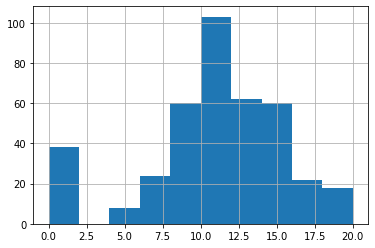

In [4]:
# Verificando a existêcia de valores nulos
df.isnull().values.any()
df['G3'].hist()

### Atributos utilizados
- **sex** student’s sex (binary: female or male)
- **age** student’s age (numeric: from 15 to 22)
- **studytime** weekly study time (numeric: 1 – < 2 hours, 2 – 2 to 5 hours, 3 – 5 to 10 hours or 4 – > 10 hours)
- **goout** going out with friends (numeric: from 1 – very low to 5 – very high)
- **failures** number of past class failures (numeric: n if 1 ≤ n < 3, else 4)
- **absences** number of school absences (numeric: from 0 to 93)
- **G1 first** period grade (numeric: from 0 to 20)
- **G2 second** period grade (numeric: from 0 to 20)


In [5]:
# Criando variável target
result = []
for row in df['G3']:
    if row >= 10:
        result.append('pass')
    else:
        result.append('fail')
df['binaryClass'] = result

In [6]:
df_ABIN = pd.DataFrame(df, columns=['sex', 'age', 'studytime', 'failures', 'goout', 'absences', 'G1', 'G2','binaryClass'])
df_ABIN.head()

,sex,age,studytime,failures,goout,absences,G1,G2,binaryClass
0,F,18,2,0,4,6,5,6,fail
1,F,17,2,0,3,4,5,5,fail
2,F,15,2,3,2,10,7,8,pass
3,F,15,3,0,2,2,15,14,pass
4,F,16,2,0,2,4,6,10,pass


In [7]:
student_features = df_ABIN.columns.tolist()
student_features.remove('binaryClass') 

In [8]:
# Dicionário usado para como suporte para consultas futuras dos valores de variáveis categóricas
dct_cat = {}

for attribute in df_ABIN:
    # Cria um dicionário com os diferentes tipos de resposta para o atributo, em seguida as respostas são enumeradas
    # Ex: d = {'F': 0, 'M': 1, ...}
    d = dict(enumerate(list(pd.unique(df_ABIN[attribute]))))
    d = {v: k for k, v in d.items()}
    
    # Realiza a troca dos valores categóricos por valores numéricos
    if type(list(d.keys())[0]) == str:
        dct_cat[attribute] = d
        df_ABIN[attribute] = df_ABIN[attribute].map(d)
dct_cat

{'sex': {'F': 0, 'M': 1}, 'binaryClass': {'fail': 0, 'pass': 1}}

In [9]:
df_ABIN.head()

,sex,age,studytime,failures,goout,absences,G1,G2,binaryClass
0,0,18,2,0,4,6,5,6,0
1,0,17,2,0,3,4,5,5,0
2,0,15,2,3,2,10,7,8,1
3,0,15,3,0,2,2,15,14,1
4,0,16,2,0,2,4,6,10,1


### Gerando Árvore

In [10]:
X = df_ABIN.drop(columns=['binaryClass'])
y = df_ABIN['binaryClass']
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.3, random_state=100)

In [11]:
X_train.shape, X_test.shape

((276, 8), (119, 8))

In [12]:
y_train.shape, y_test.shape

((276,), (119,))

In [13]:
# Instânciando objeto classificador
tree_ABIN = DecisionTreeClassifier(random_state=0)

In [14]:
#Treinando modelo de árvore de decisão
tree_ABIN = tree_ABIN.fit(X_train, y_train)

In [15]:
for feature, importancia in zip(df_ABIN.columns, tree_ABIN.feature_importances_):
    print("{}: {}".format(feature,importancia))

sex: 0.0036038153436355447
age: 0.036494203692136185
studytime: 0.018244315177154944
failures: 0.03149608735322842
goout: 0.03169900077076485
absences: 0.05324802650021379
G1: 0.07129226628352726
G2: 0.753922284879339


In [16]:
predictions = tree_ABIN.predict(X_test)
print('Precisão de {}%'.format((metrics.accuracy_score(y_true = y_test, y_pred = predictions))*100))

Precisão de 87.39495798319328%


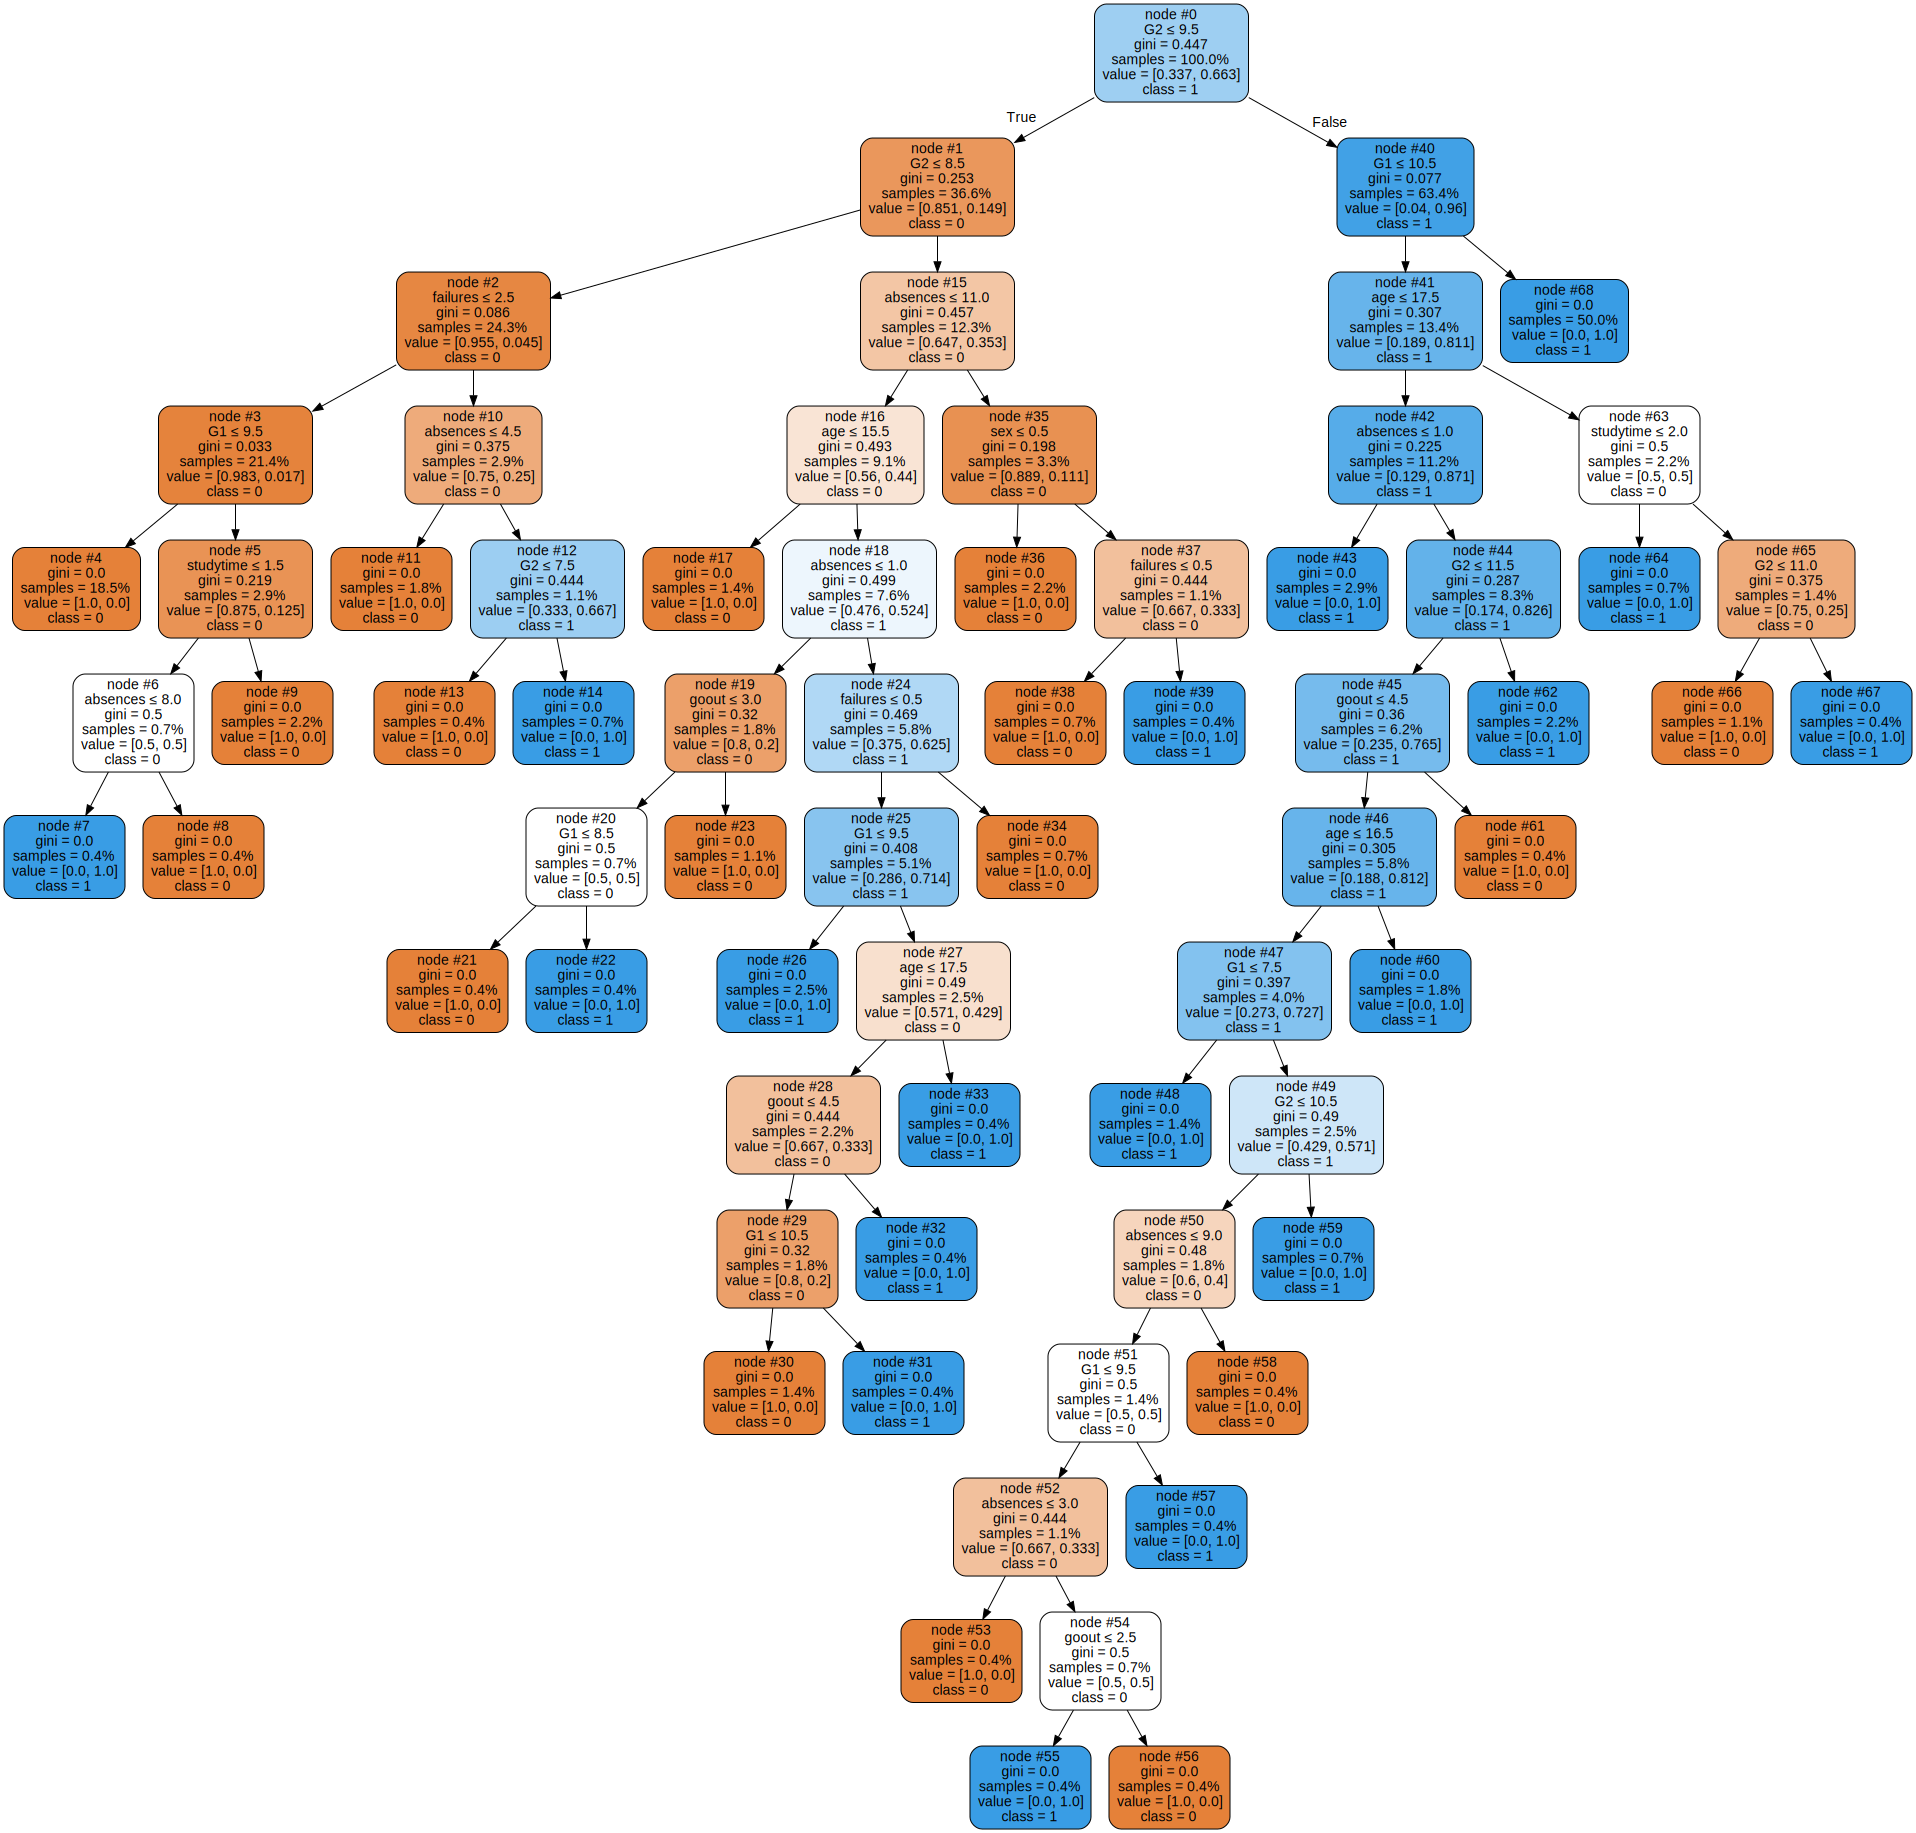

In [17]:
dot_data = export_graphviz(tree_ABIN, 
                          out_file = None,
                          feature_names = student_features,
                          class_names = ['0','1'],
                          filled = True, rounded = True,
                          proportion = True,
                          node_ids = True,
                          rotate = False,
                          label = 'all',
                          special_characters = True)
graph = graphviz.Source(dot_data)
graph

In [18]:
from sklearn import tree
x,y = df_ABIN.drop(columns=['binaryClass']), df_ABIN['binaryClass']

class_label = ['0','1']

def plot_tree(crit, split, depth, min_samples_split, min_samples_leaf = 0.2):
    estimator = DecisionTreeClassifier(
                                        random_state = 0
                                        ,criterion = crit
                                        ,splitter = split
                                        ,max_depth = depth
                                        ,min_samples_split = min_samples_split
                                        ,min_samples_leaf = min_samples_leaf)
    estimator.fit(x,y)
    graph = Source(export_graphviz(estimator,
                                  out_file = None
                                  ,feature_names=student_features
                                  ,class_names = class_label
                                  ,impurity = True
                                  ,filled = True))
    display(SVG(graph.pipe(format='svg')))
    return estimator

inter = interactive(plot_tree
                 ,crit = ['gini','entropy']
                 ,split = ['best','random']
                 ,depth = [1,2,3,4,5,10,20,30]
                 ,min_samples_split = (1,5)
                 ,min_samples_leaf = (1,5))
display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…